## Naive Method : Explore and then quickly exploit

The following algorithm uses a very naive but intutitve approach. Here the assumption (as stated on the problem) that the structure of the losses given the three arms are known. Arm 3 will have Ber(1/2) with costs being 0 or (2,3) depending on what the parameters for arms 1 and 2 are. Thus, the naive approach is to sample arm 3 until a cost is incurred, and then based on this map to the arm given the relationship. Thus, the given structure allows us to have a very high confidence about what the optimal arm is.

3
Average loss thus far (should be < smaple mean): 1.0


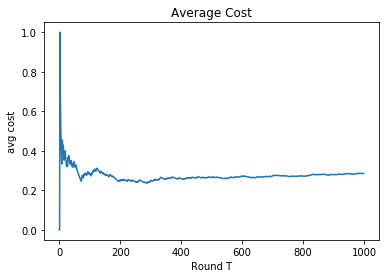

In [8]:
from pylab import figure, axes, pie, title, show
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

#import scipy.io as spio

# Setup the cost arrays based on the bernoulli distributions
T = 1000
# True mean

mean1 = 0.7
mean2 = 0.3

# can think about t3 as the learning parameter
def naiveMethod(t3, T, mean1, mean2) :
    # note costs are either 0 or 1
    avg_loss = np.zeros(T)
    loss = np.zeros(T)
    arm1_cost = np.random.binomial(1, mean1, (1,T))
    arm2_cost = np.random.binomial(1, mean2, (1,T))


    # Costs of arm 3 depend on the size of means
    if (mean1 > mean2) :
        cost3 = 3
    else :
        cost3 = 2
        
    arm3_cost = np.random.binomial(1, 0.5, (1, T)) * cost3
    
    cum_reward = 0
    reward_time = 0
    i = 0
    while (cum_reward == 0) :
        sample_reward = arm3_cost[0][i]
        #print(smaple_reward)
        cum_reward += sample_reward
        loss[i] = loss[i - 1] + sample_reward
        avg_loss[i] = loss[i] / (i + 1)
        cum_reward = loss[i]
        i += 1 # i here is the number of samples
        
        #if (sample_reward > 0) :
        #    reward_time += 1

    median = 2.5

    t3 = i # This is bug ... should be fixed. Original code had t3 fixed, however I changed it such that the 
            # first t3 = the number of rounds until a loss > 0 is sampled from arm 3
    print(t3)
    print("Average loss thus far (should be < smaple mean):", np.sum(avg_loss))
    
    
    if (cum_reward >=  median) : # reward is 4,
        opt_arm = arm2_cost[0][t3:T-1] # arm 2 is min cost
        opt_arm_full = arm2_cost[0]
    else : 
        opt_arm = arm1_cost[0][t3: T-1] # arm1 is min cost run that one
        opt_arm_full = arm1_cost[0]
    
    
    for i in range(t3, T) :
        loss[i] += loss[i - 1] + opt_arm_full[i]
        avg_loss[i] = loss[i] / (i + 1)
        
    total_cost = loss[-1] / T
    return total_cost, avg_loss

total_cost, avg_cost = naiveMethod(1, T, mean1, mean2)

plt.plot(avg_cost)
plt.title('Average Cost')
plt.xlabel('Round T')
plt.ylabel('avg cost')
plt.savefig('avg_naive.png')



## Thompson sampling: 2 armed bandit with Beta posterior 

The beauty of thomspon sampling: naturally explores then exploits. In this case, we have two parameters. In this case we explore 3 arms. Note that the on average, with T reaching a large number the average cost should around 0.3 (the optimal arm). However when T is not large enough we encounter a lot of costs given that we are exploring arm 3. 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


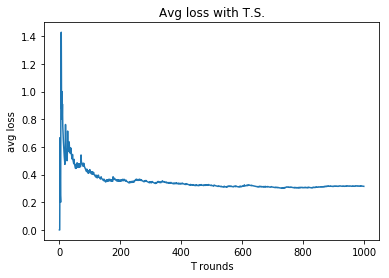

In [9]:
# Apply thompson sampling for the two arms
# means

def ThompsonSampling (T) :
    mu1 = 0.7
    mu2 = 0.3
    mu3 = 0.5


    # define time horizon


    # calculate the given loss arrays
    arm1_cost = np.random.binomial(1, mu1, (1,T))
    arm2_cost = np.random.binomial(1, mu2, (1,T))
    arm3_cost = np.random.binomial(1, mu3, (1,T)) * 3

    arm_costs = np.array([arm1_cost, arm2_cost, arm3_cost])

    # draw from beta distribution
    avg_loss = np.zeros(T)
    loss_arr = np.zeros(T)

    # Initialize parameters to uniform over all
    param1 = np.array([1,1])
    param2 = np.array([1,1])
    param3 = np.array([1,1])

    for i in range(T) :
        w1 = np.random.beta(param1[0], param1[1])
        w2 = np.random.beta(param2[0], param2[1])
        w3 = np.random.beta(param3[0], param3[1])

        # pick arm that minizmized the expected loss (or minimizes reward) i.e. with min w parameter

        # Probably easier and more efficient way of extracting arm using indexing ... ignoring for now
        theta = np.array([])
        if (w1 < np.minimum(w2, w3)) :
            arm = 0
        elif (w2 < np.minimum(w1,w3)):
            arm = 1
        elif (w3 < np.minimum(w1,w2)) :
            arm = 2

        # Pick arm 
        arm_array = arm_costs[arm]
        # get loss
        loss = arm_array[0][i]

        # update alpha and beta parameters depending on arm
        if (arm == 0) :
              param1 += np.array([loss, 1 - loss])
        elif (arm == 1) : 
              param2 += np.array([loss, 1 - loss])
        else :
              param3 += np.array([loss, 3 - loss])

        # Define loss vector
        loss_arr[i] = loss    
        # get the  average loss
        avg_loss[i] = (loss + np.sum(loss_arr)) / (i + 1)
        
    return avg_loss

avg_loss_ts = ThompsonSampling(T)
plt.title('Avg loss with T.S.')
plt.xlabel('T rounds')
plt.ylabel('avg loss')

plt.plot(avg_loss_ts)
plt.show()

## Comparing Plots

5
Average loss thus far (should be < smaple mean): 0.6


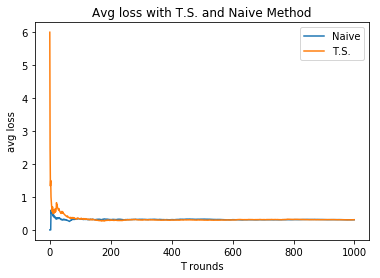

In [10]:
plt.title('Avg loss with T.S. and Naive Method')
plt.xlabel('T rounds')
plt.ylabel('avg loss')

T = 1000
nothing, avg_loss_naive = naiveMethod(2, T, 0.7, 0.3)
avg_loss_ts = ThompsonSampling(T)
plt.plot(avg_loss_naive)
plt.plot(avg_loss_ts)
plt.legend(['Naive', 'T.S.'])
plt.show()

## Problem 2: Extra Credit

In [306]:
# define finite time horizon 
T = 1000

# define a few sequences 

#stochastic 
stochastic_seq = np.random.binomial(1, 0.5, (1,T))

#0101.. sequnce
sequence1_list = [0,1]*int(T/2)
sequence2_list = [0, 0, 1, 1]*int(T/4)
periodic1_seq = np.array(sequence1_list)
periodic2_seq = np.array(sequence2_list)


# We will test compared to the sequences above
# define optimal sequence with switch ending in 1
def opt_seq_end1(seq) :
    T = len(seq)
    seq_ref = np.ones(T)
    losses = np.zeros(T)
    if (np.sum(np.absolute(np.array(seq_ref) - np.array(seq))) == 0) :
        losses = 0
        k = 0
    else :
        for i in range(T - 1) :
            seq_ref[i] = 0
            losses[i] = np.sum(np.absolute((np.array(seq_ref) - np.array(seq))))
        k = np.argmin(losses)
    #print("For 1:", k, losses[k])
    return k, losses


# optimal sequnce with switch ending in zero
def opt_seq_end0(seq) :
    T = len(seq)
    #print("Seq pass in ", seq)
    seq_ref = np.zeros(T)
    losses = np.zeros(T)
    if (np.sum(np.absolute(np.array(seq_ref) - np.array(seq))) == 0) :
        losses = 0
        k = 0
    else :
        for i in range(T - 1) :
            seq_ref[i] = 1
            #print("Ref Seq after mod", seq_ref)
            losses[i] = np.sum(np.absolute(np.array(seq_ref) - np.array(seq)))
        k = np.argmin(losses)
    #print("For 0:", k, losses[k])
    return k, losses

def multiClassMW(sequence, eta = 0.1) :
    T = len(sequence)
    weights = np.array([.5, .5])
    kopt, opt_loss = opt_seq_end1(sequence)
    optimal_loss = np.absolute(opt_loss)
    regret_time_T = np.zeros(T)
    losses = np.zeros(T)
    cum_loss = np.zeros(T)
    x_observed = []
    
    for i in range (T) :
        #print(weights.shape)
        w1 = weights[0]
        w2 = weights[1]
        
        if (w1 > w2) :
            w_max = 1 - w1 # in other words pick zero with probablility w1 which mean get one with probability 1 - w1
            #print("Optimal is 0")
        else :
            w_max = w2 # pick 1 with this probablily
            #print("optimal is 1")
        x_hat = np.random.binomial(1, w_max)
        #print("Predicted at round",i, 'x=',x_hat)
        x_true = sequence[i]
        if (i == 0) :
            x_observed = np.array([x_true])
        else :
            x_observed = np.concatenate((x_observed, x_true), axis = None)
        if (x_true != x_hat) :
            loss_t = 1
        else : 
            loss_t = 0
        losses[i] = loss_t
        cum_loss[i] += cum_loss[i - 1] + loss_t
    
        # update parameters
        k1, losses0 = opt_seq_end0((x_observed))
        k2, losses1 = opt_seq_end1((x_observed))
        
        l0 = losses[k1]
        l1 = losses[k2]
            
        e0 = np.exp(- eta * l0)
        e1 = np.exp(- eta * l1)
        
        #print(l0, l1)
        #print("obs", x_observed)
        #print("guess",x_hat)
        weights[0] = e0 / (e1 + e0)
        weights[1] = e1 / (e1 + e0)
        #print("losses", losses0[k1], losses1[k2])
        #print('Cons e', e0, e1)
        #print("Weights", weights)
    print("done")
    return losses, cum_loss, optimal_loss

ones = np.ones(500)
zeros = np.zeros(500)
easy_seq = np.concatenate((zeros, ones), axis = None)
stochastic_seq = stochastic_seq[0]


loss_period1, cumloss_period1, optloss_period1 = multiClassMW(periodic1_seq)
loss_period2, cumloss_period2, optloss_period2 = multiClassMW(periodic2_seq)
loss_stoch, cumloss_stoch, optloss_stoch = multiClassMW(np.array(stochastic_seq))
loss_easy, cumloss_easy, optloss_easy = multiClassMW((easy_seq))


done
done
done
done


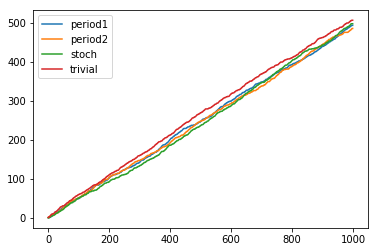

In [307]:
# consider an easy sequence too

plt.plot(cumloss_period1)
plt.plot(cumloss_period2)
plt.plot(cumloss_stoch)
plt.plot(cumloss_easy)
plt.legend(['period1','period2', 'stoch', 'trivial'])
plt.show()